## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras_core as keras
from models.analytical import SingleOccupationSingleIsotope, MultiOccupationMultiIsotope, TrapDiffusion
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

Using PyTorch backend.


## Definitions

In [52]:
class CPUModel:
    @staticmethod
    def extract(pinn):
        weights = []
        biases = []
        activations = []
        for layer in pinn.layers:
            weights.append(layer.get_weights()[0])
            biases.append(layer.get_weights()[1])
            activations.append(layer.activation.__name__)
        return weights, biases, activations
    
    def __init__(self, model, include_params = False):
        self.weights, self.biases, self.activations = CPUModel.extract(model)
        self.include_params = include_params
        self.name = model.name

    def predict(self,x):
        for layer, bias, activation in zip(self.weights, self.biases,self.activations):
            x = x @ layer + bias
            if activation == 'relu':
                x[x < 0] = 0
            elif activation == 'linear':
                ...
            else:
                raise NotImplementedError(f"Activation {activation} not implemented")
        return x
    
def measure_performance(analytical_model: type[TrapDiffusion],surrogate_model,target_batch_size = 1, average = 1000):
    inputs, _ = analytical_model.training_data(n_eval=1000, include_params=surrogate_model.include_params)
    batch_size = inputs.shape[0]

    if target_batch_size > batch_size:
        raise ValueError(f"Target batch size {target_batch_size} is larger than the training batch size {batch_size}")
    start = time.perf_counter()
    for _ in range(average):
        predictions = surrogate_model.predict(inputs[:target_batch_size])
        results = analytical_model.targets_reverse_transform(predictions)
    end = time.perf_counter()
    t = (end-start)/average/target_batch_size
    return t

def performance_batch_size_plot(analytical_model: type[TrapDiffusion], surrogate_model):
    factors = {
        "s" : 1,
        "ms" : 1e3,
        "µs" : 1e6,
        "ns" : 1e9
    }
    batch_sizes = np.arange(10,1000,10)
    times = []
    for batch_size in tqdm(batch_sizes,leave=False):
        t_s = measure_performance(analytical_model,surrogate_model,target_batch_size=batch_size,average = 50)
        times.append(t_s)


    times = np.array(times)
    unit = "µs"
    min_pos = np.argmin(times)
    best_time = times[min_pos]
    best_batch_size = batch_sizes[min_pos]
    plt.plot(batch_sizes,times*factors[unit])
    plt.title(f"CPU inference\n{surrogate_model.name}\n")
    plt.annotate(
        f"{best_batch_size} @ {best_time*factors[unit]:.2f}{unit}",
         (best_batch_size,best_time*factors[unit]),
         horizontalalignment="center",
            xytext=(best_batch_size + 20,best_time*factors[unit]*2),
            arrowprops=dict(
                facecolor='black',
                width = 0.5,
                shrink = 0.05,
                headwidth = 5,
                headlength = 5
                ),
         )
    plt.xlabel("Batch size")
    plt.grid()
    plt.ylabel(f"Time per prediction [{unit}]")



## Sanity checks

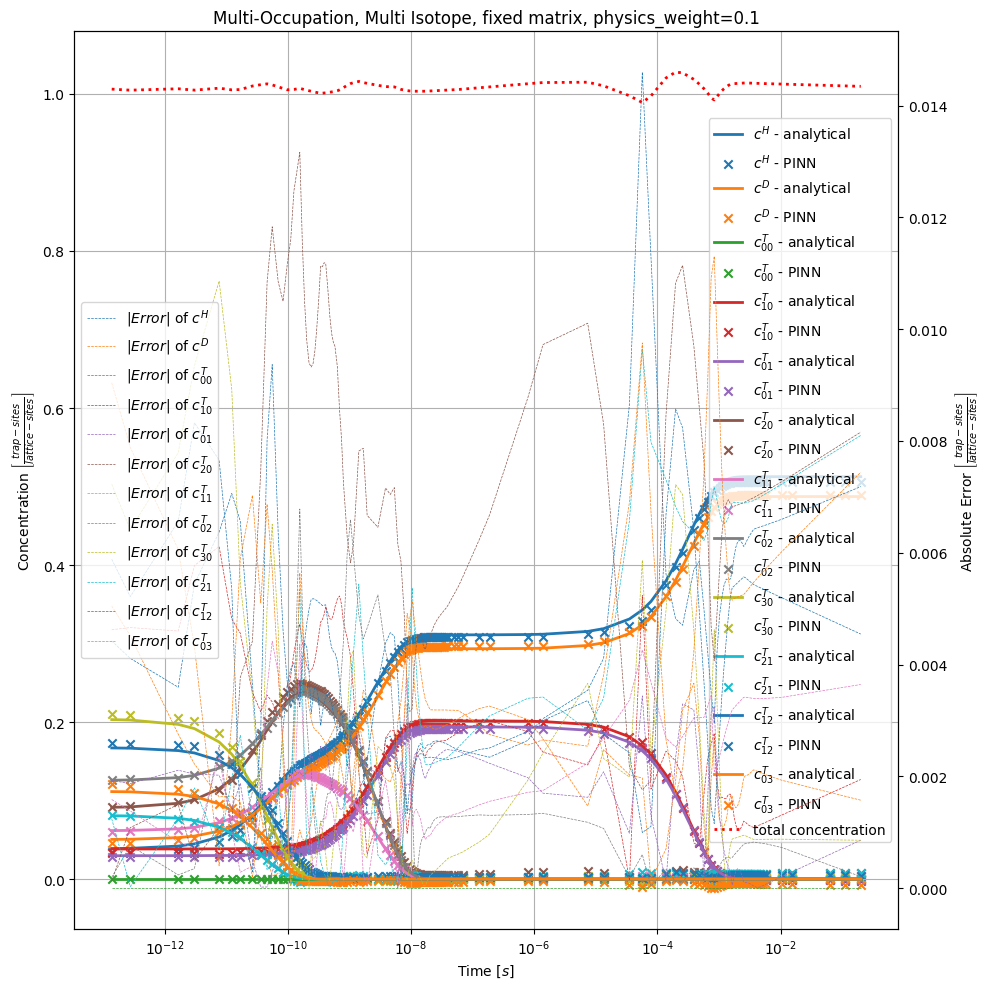

In [4]:
momi_physics = keras.models.load_model('trained_models/MOMI_fixed_physics.keras', compile=False)
momi_physics_cpu = CPUModel(momi_physics)
np.random.seed(0)
momi_analytical = MultiOccupationMultiIsotope()
plt.figure(figsize=(10,10))
momi_analytical.evaluate(momi_physics_cpu, include_params=momi_physics_cpu.include_params)

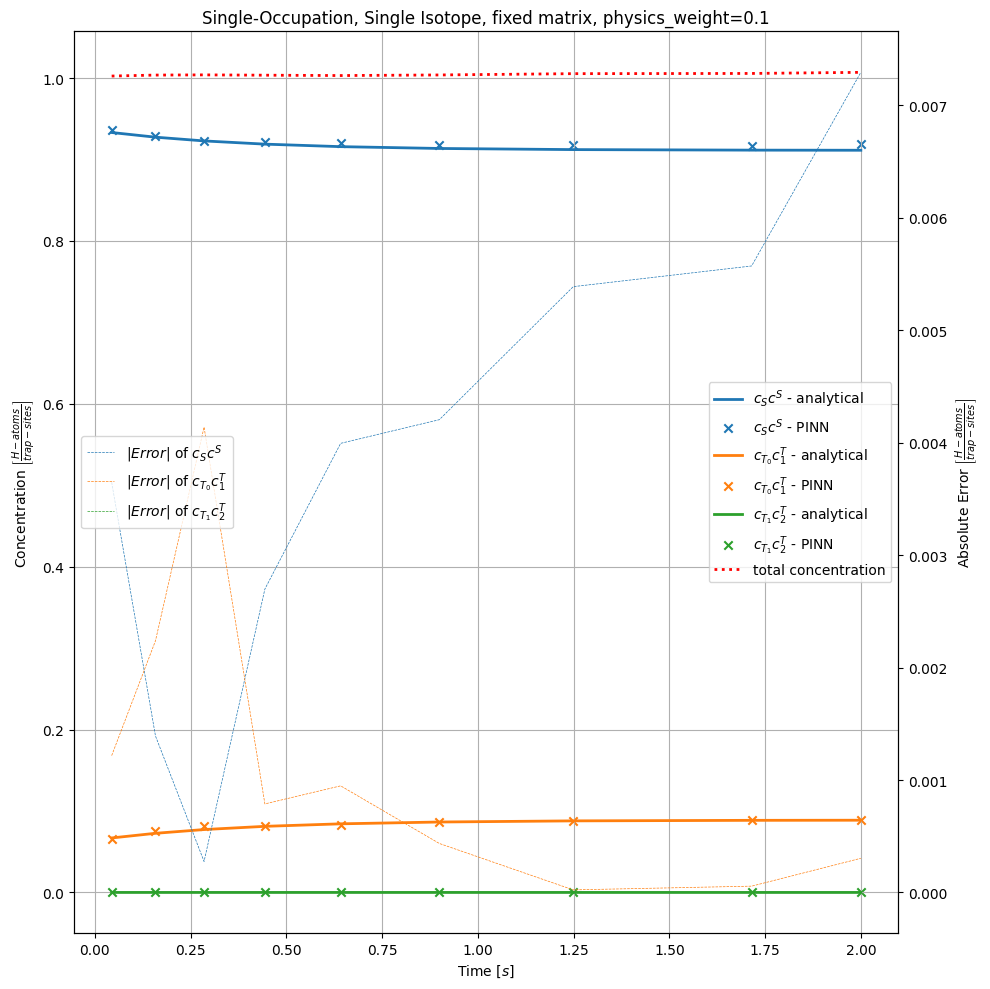

In [5]:
sosi_physics = keras.models.load_model('trained_models/SOSI_fixed_physics.keras', compile=False)
sosi_physics_cpu = CPUModel(sosi_physics)
np.random.seed(1)
sosi_analytical = SingleOccupationSingleIsotope()
plt.figure(figsize=(10,10))
sosi_analytical.evaluate(sosi_physics_cpu, include_params=sosi_physics_cpu.include_params)

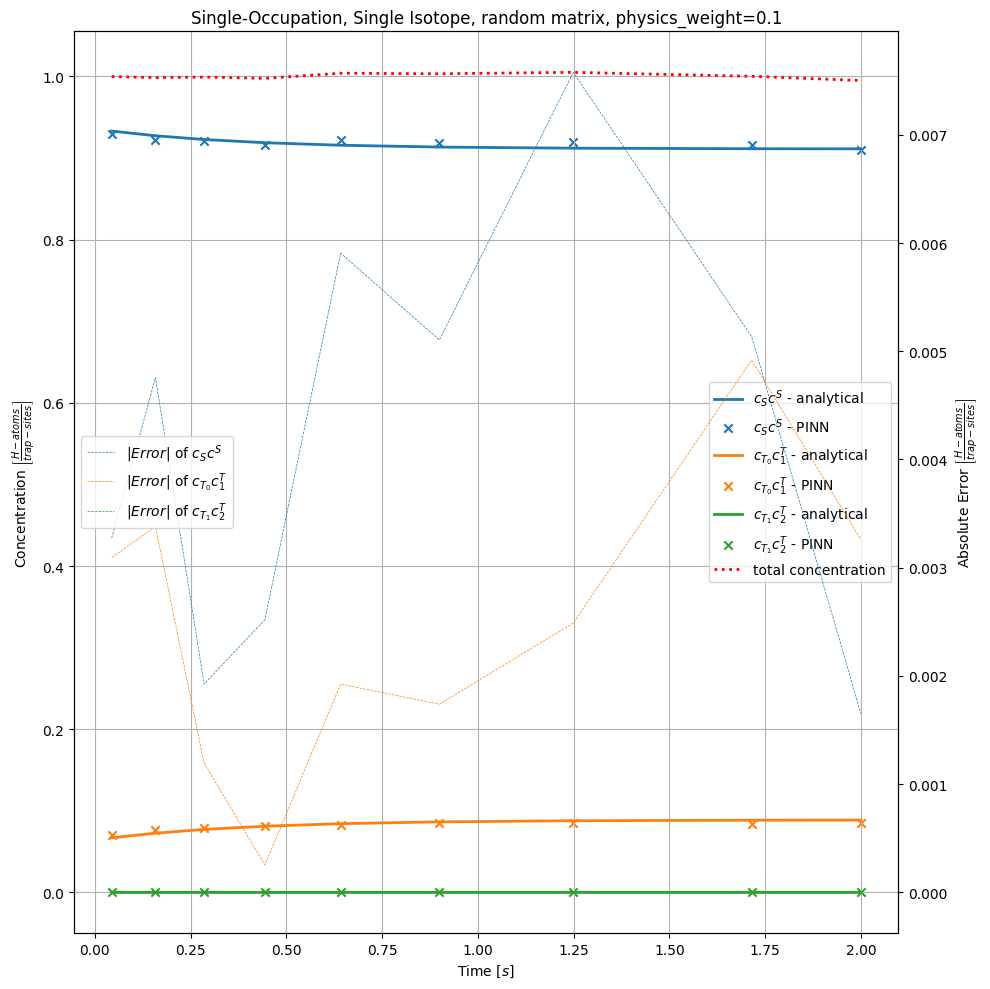

In [51]:
sosi_physics_random = keras.models.load_model('trained_models/SOSI_random_physics.keras', compile=False)
sosi_physics_random_cpu = CPUModel(sosi_physics_random, include_params=True)
np.random.seed(1)
sosi_analytical = SingleOccupationSingleIsotope()
plt.figure(figsize=(10,10))
sosi_analytical.evaluate(sosi_physics_random_cpu, include_params=sosi_physics_random_cpu.include_params)

## Benchmarks

  0%|          | 0/99 [00:00<?, ?it/s]

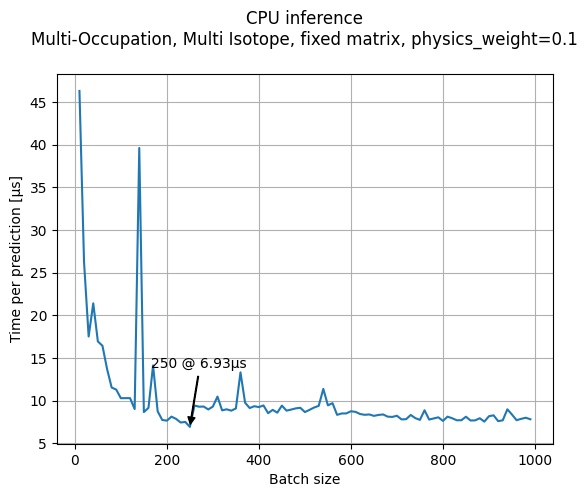

In [48]:
performance_batch_size_plot(momi_analytical,momi_physics_cpu)

  0%|          | 0/99 [00:00<?, ?it/s]

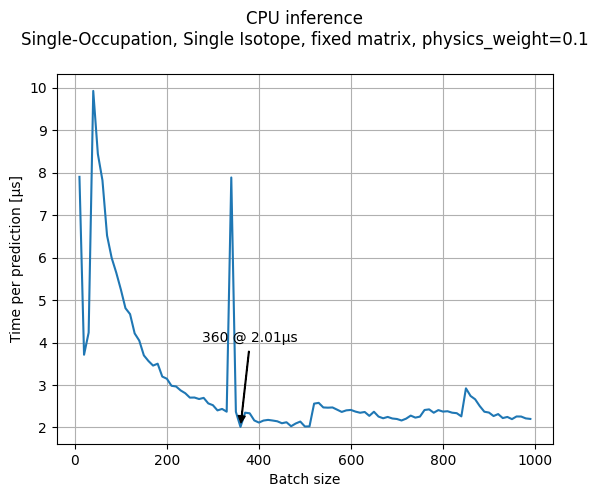

In [49]:
performance_batch_size_plot(sosi_analytical,sosi_physics_cpu)

  0%|          | 0/99 [00:00<?, ?it/s]

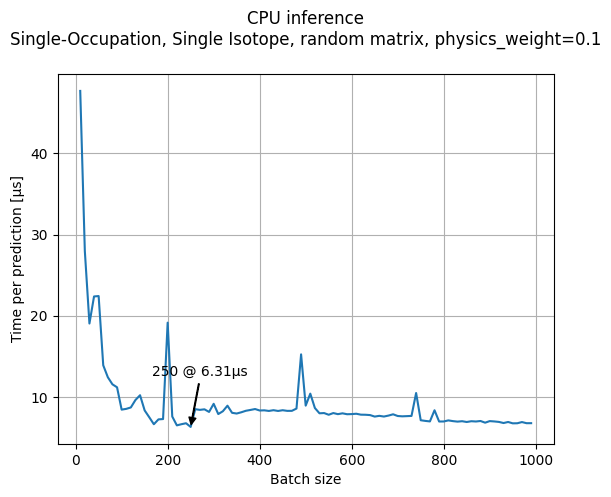

In [53]:
performance_batch_size_plot(sosi_analytical,sosi_physics_random_cpu)